# To do for 20/Oct
1. Test als with rank=100 for random tensor (ok)
2. Test als kruskal tensor (ok)
3. implementer her-CPRAND (sample kahtrihao CPRAND existe déjà dans tensorly) et trouver les paramètres (gama bar, beta bar plus petits peut etre cf article her)
4. comparaison des algos (3 versions) en fonction du temps (t) et it cf doc her (court et long). --> il a trouvé que pour les tensors simple, her sert à rien.
5. Pour les entrées de factors non negative, her marche mieux. Est ce le cas pour her-CPRAND ? (ligne 6, A>=0)
6. Optimiser le code pour her_CPRAND

In [ ]:
pip install -U tensorly

In [128]:
import numpy as np

In [129]:
import tensorly as tl

In [130]:
import matplotlib.pyplot as plt

In [131]:
from tensorly.decomposition import sample_khatri_rao

# Basic operations

### Creation of tensors

In [ ]:
# create a random 3x3x3 tensor
t_rand = np.random.random((3, 3, 3))

In [ ]:
# create a constant 3x4x2 tensor
t_cons = tl.tensor(np.arange(24,dtype='d').reshape((3, 4, 2)))

In [138]:
# create a kruskal tensor
# factor matrices
A=np.arange(9).reshape(3,3)
B=np.arange(6).reshape(2,3)+9
C=np.arange(6).reshape(2,3)+15
factors=[]
factors+=[A]
factors+=[B]
factors+=[C]
weights,factors=tl.cp_tensor.cp_normalize((None,factors)) 
t_krus = tl.cp_to_tensor((weights,factors))

In [ ]:
weights

array([2357.67364154, 3309.71569776, 4506.92899878])

In [ ]:
factors[0]

array([[0.        , 0.12309149, 0.20739034],
       [0.4472136 , 0.49236596, 0.51847585],
       [0.89442719, 0.86164044, 0.82956136]])

In [ ]:
factors[1]

array([[0.6       , 0.60971076, 0.61782155],
       [0.8       , 0.79262399, 0.78631834]])

In [ ]:
factors[2]

array([[0.6401844 , 0.64413575, 0.64764842],
       [0.76822128, 0.7649112 , 0.76193932]])

In [ ]:
t_cons

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]])

In [ ]:
# squared Frobenius norm 
tl.norm(t_cons,2)**2

4323.999999999999

In [ ]:
# show frontal slices
t_cons[..., 0]

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]])

In [ ]:
t_cons[..., 1]

array([[ 1.,  3.,  5.,  7.],
       [ 9., 11., 13., 15.],
       [17., 19., 21., 23.]])

### Unfolding

In [ ]:
# mode-1 unfolding (i.e. zeroth mode)
unfolded = tl.unfold(t_cons, mode=0)

In [ ]:
print(unfolded)

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]]


In [ ]:
# refold the unfolded tensor
tl.fold(unfolded, mode=0, shape=t_cons.shape)

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]])

### Other basic operations

In [ ]:
# dimension of tensor
tl.shape(t_rand)

(3, 3, 3)

# Decomposition

### ALS

In [ ]:
# stopping criteria 
def err(tensor,weight,factors): 
  t_tilde=tl.kruskal_to_tensor((weight,factors)) # transform tensor decomposition (kruskal tensor) to tensor
  return(tl.norm(tensor-t_tilde))

In [ ]:
# ALS method to compute tensor decomposition
def als(tensor,rank,it_max=100,tol=1e-5):
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[] # list of factor matrices
  # Initializtion of factor matrices by left singular vectors
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) # first rank eigenvectors/values (ascendent)
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  # sometimes we have singular matrix error
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors)) # normalise factor matrices
  it=0
  error=[err(tensor,weights,factors)/norm_tensor]
  while (error[len(error)-1]>tol and it<it_max): 
    for n in range(N):
      V=np.ones((rank,rank))
      for i in range(len(factors)):
        if i != n : V=V*tl.dot(tl.transpose(factors[i]),factors[i])
      W=tl.cp_tensor.unfolding_dot_khatri_rao(tensor, (None,factors), n) # do I need to reverse factors ? --> no deja bon ordre (même matricization que dans le chapitre)
      factors[n]= tl.transpose(tl.solve(tl.transpose(V),tl.transpose(W)))
    weights,factors=tl.cp_tensor.cp_normalize((None,factors))
    it=it+1
    error.append(err(tensor,weights,factors)/norm_tensor)
  return(weights,factors,it,error)

#### Test

In [ ]:
# test err
tensor=tl.tensor(np.arange(12,dtype='d').reshape((3, 2, 2)))
err(tensor,None,factors) # with factors of t_krus

NameError: ignored

In [ ]:
# test als with a random tensor, rank = 3 (order)
weights,factors,it,error=als(t_rand,3)
tl.kruskal_to_tensor((weights,factors))

array([[[0.85246198, 0.36474356, 0.90508098],
        [0.47107042, 0.08714579, 0.25079474],
        [0.88009196, 0.94653382, 0.20147073]],

       [[0.24697925, 0.34971545, 0.12977341],
        [0.76543105, 0.86956049, 0.61198147],
        [0.77780261, 0.76612332, 0.71077175]],

       [[0.7218168 , 0.75701287, 0.47140794],
        [0.74666465, 0.39177018, 0.68204332],
        [0.89206894, 0.32226626, 0.94492172]]])

In [ ]:
from tensorly.decomposition import parafac

In [ ]:
# compare with parafac in tensorly
kt=parafac(t_rand,3)
tl.kruskal_to_tensor(kt)

In [ ]:
# compare with the initial tensor
t_rand

In [ ]:
# test als with a random tensor, rank = 100
weights,factors=als(t_rand,100)
tl.kruskal_to_tensor((weights,factors))

In [ ]:
# test als with a Kurskal tensor
weights,factors=als(t_krus,3)
weights

In [ ]:
factors[0]

In [ ]:
factors[1]

In [ ]:
factors[2]

In [ ]:
tl.kruskal_to_tensor((weights,factors))

In [ ]:
# compare with the initial tensor
t_krus

We obtain the same tensor, but not the same decomposition (weights and factors are different from the definition of t_krus), because of permutation and normalization.

**Questions :**


1.   multi_mode_dot : formule ? Reverse factors ? --> No
2.   rank <= N1? singular matrix lorsque rank>N1 --> inevitable
3.   ça ne converge pas ? --> normal
4.   pseudo-code : où normaliser les factor matrices ?
5.   CPRAND : retrieve idx ?



**Remarks :**


1.   useless to initialize mode=0 factor matrix




### her-CPRAND



**Questions**

1.   algo comparaison : condition number to 100, log scale ? P4
2.   parameter researche : hungarian algo
3.   f-fmin est grand (pour parameter et comparaison)





#### Stopping criteria

In [148]:
# Stopping criteria of CPRAND
def err_rand(tensor,weights,factors,nb_samples): # P should be little than the total number of indices, otherwise no sense.
  indices_list = [np.random.randint(0, tl.shape(m)[0], size=nb_samples, dtype=int) for m in factors] 
  indices_list = [i.tolist() for i in indices_list]
  indices_list = tuple(indices_list)
  est_values=[]
  P=1
  for i in tl.shape(t_krus) : P=P*i
  for i in range(nb_samples):
     value=weights
     for mode in range(tl.ndim(tensor)) :
       value=value*factors[mode][indices_list[mode][i],:]
     est_values+=[sum(value)]
  return(np.sqrt(sum((tensor[indices_list]-est_values)**2)*P/nb_samples)) 

##### Test for err

In [139]:
indices_list=[np.random.randint(0, tl.shape(m)[0], size=4, dtype=int) for m in factors]

In [140]:
indices_list = [i.tolist() for i in indices_list]
indices_list = tuple(indices_list) 
indices_list

([2, 0, 1, 2], [1, 0, 1, 1], [0, 1, 1, 1])

In [141]:
t_krus[indices_list] 

array([4440.,  630., 3036., 5265.])

In [142]:
est_values=[]
for i in range(4) : # P 
  value=weights
  for mode in range(tl.ndim(t_krus)) : 
     value=value*factors[mode][indices_list[mode][i],:]
  est_values+=[sum(value)]

In [143]:
est_values

[4440.0, 630.0, 3036.0, 5265.0]

In [149]:
err_rand(t_krus,weights,factors,4)

9.646648066153113e-13

#### Main method

In [188]:
# exact_err indicates whether we use exact error calculation or randomised error calculation
# we stop the algorithm if min_err is not updated for err_it_max iterations

def her_CPRAND(tensor,rank,n_samples,exact_err=False,it_max=100,err_it_max=20,tol=1e-3,beta=0.3,eta=2,gamma=1.05,gamma_bar=1.1):
  beta_bar=1
  N=tl.ndim(tensor) # order of tensor
  norm_tensor=tl.norm(tensor) # norm of tensor
  factors=[]

  # Initializtion of factor matrices by left singular vectors (same as in als)
  for mode in range(N):
    unfolded=tl.unfold(tensor, mode)
    if rank<=tl.shape(tensor)[mode] : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=rank) 
    else : 
      u,s,v=tl.partial_svd(unfolded,n_eigenvecs=tl.shape(tensor)[mode]) 
      u=np.append(u,np.random.random((np.shape(u)[0],rank-tl.shape(tensor)[mode])),axis=1)  
    factors+=[u]
  weights,factors=tl.cp_tensor.cp_normalize((None,factors)) 
  # Initialization of factor hat matrice by factor matrices
  factors_hat=factors
  F_hat_bf=tl.norm(tensor-tl.cp_to_tensor((weights,factors)),2) # cost

  it=0
  err_it=0
  if(exact_err==False):
    error=[err_rand(tensor,weights,factors,int(10*rank*np.log(rank)+1))/norm_tensor] 
  else :
    error=[err(tensor,weights,factors)/norm_tensor]
  min_err=error[len(error)-1]
  rng = tl.random.check_random_state(None)
  while (min_err>tol and it<it_max and err_it<err_it_max): 
    for n in range(N):
      Zs,indices=tl.decomposition.sample_khatri_rao(factors_hat,n_samples,skip_matrix=n,random_state=rng)
      indices_list = [i.tolist() for i in indices]
      indices_list.insert(n, slice(None, None, None))
      indices_list = tuple(indices_list)
      if (n==0) :sampled_unfolding = tl.transpose(tensor[indices_list]) # because of the matricization
      else : sampled_unfolding =tensor[indices_list]
      factor_bf=factors[n]
      # update
      factors[n] = tl.transpose(tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))) # solve needs a squared matrix
      if (n==N-1) : F_hat_new=tl.norm(tl.dot(Zs,tl.transpose(factors[n]))-sampled_unfolding,2) # cost update
      # extrapolate
      factors_hat[n]=factors[n]+beta*(factors[n]-factor_bf)

    if (F_hat_new>F_hat_bf):
      weights,factors = tl.cp_tensor.cp_normalize((None,factors))
      factors_hat=factors
      beta_bar=beta
      beta=beta/eta
    else :
      weights,factors = tl.cp_tensor.cp_normalize((None,factors_hat))
      beta_bar=min(1,beta_bar*gamma_bar)
      beta=min(beta_bar,gamma*beta)
    F_hat_bf=F_hat_new
    it=it+1
    if(exact_err==False):
      error.append(err_rand(tensor,weights,factors,int(10*rank*np.log(rank)+1))/norm_tensor)
    else : error.append(err(tensor,weights,factors)/norm_tensor)
    if(error[len(error)-1]<min_err) : min_err=error[len(error)-1] # err update
    else : err_it=err_it+1
  return(weights,factors,it,error)

##### Test 

###### Test sample_kahtri_rao

In [ ]:
# test sample_kahtri_rao
Zs,indices=tl.decomposition.sample_khatri_rao(factors,2,skip_matrix=1)

/usr/local/lib/python3.6/dist-packages/tensorly/decomposition/_cp.py:604: UserWarning: You are creating a new random number generator at each call.
If you are calling sample_khatri_rao inside a loop this will be slow: best to create a rng outside and pass it as argument (random_state=rng).
  warnings.warn('You are creating a new random number generator at each call.\n'


In [ ]:
t_krus[...,0]

array([[ 534.,  684.],
       [1980., 2562.],
       [3426., 4440.]])

In [ ]:
t_krus[...,1]

array([[ 630.,  807.],
       [2346., 3036.],
       [4062., 5265.]])

In [ ]:
factors

[array([[0.        , 0.12309149, 0.20739034],
        [0.4472136 , 0.49236596, 0.51847585],
        [0.89442719, 0.86164044, 0.82956136]]),
 array([[0.6       , 0.60971076, 0.61782155],
        [0.8       , 0.79262399, 0.78631834]]),
 array([[0.6401844 , 0.64413575, 0.64764842],
        [0.76822128, 0.7649112 , 0.76193932]])]

In [ ]:
tl.tenalg.khatri_rao(factors,skip_matrix=1)

array([[-7.49125408e-07,  2.62419513e+02,  6.05352789e+02],
       [-8.98950490e-07,  3.11623172e+02,  7.12179752e+02],
       [ 6.74999997e+02,  1.04967805e+03,  1.51338197e+03],
       [ 8.09999996e+02,  1.24649269e+03,  1.78044938e+03],
       [ 1.35000003e+03,  1.83693651e+03,  2.42141120e+03],
       [ 1.62000004e+03,  2.18136210e+03,  2.84871906e+03]])

In [ ]:
Zs # line 5 and 3

array([[1350.00003412, 1836.93650543, 2421.41119956],
       [ 674.99999656, 1049.67805344, 1513.38197013]])

In [ ]:
indices

[array([1, 1]), array([0, 1])]

In [ ]:
indices_list = [i.tolist() for i in indices]

In [ ]:
indices_list.insert(1, slice(None, None, None))

In [ ]:
indices_list

[[1, 1], slice(None, None, None), [0, 1]]

In [ ]:
indices_list = tuple(indices_list)

In [ ]:
sampled_unfolding = t_krus[indices_list]

In [ ]:
sampled_unfolding

array([[3426., 4440.],
       [1980., 2562.]])

In [ ]:
sampled_unfolding = tl.transpose(t_krus[indices_list])

In [ ]:
tl.solve(tl.dot(tl.transpose(Zs),Zs),tl.dot(tl.transpose(Zs),sampled_unfolding))

array([[ 1023.30028924, -1093.43495461,  6201.96856949],
       [-1727.69563215,  6110.96759931, -5688.58900876],
       [ 2048.        ,    -0.        ,  8192.        ]])

###### Test her_CPRAND

In [151]:
# with a cp_tensor (order=3)
rank=4
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error=her_CPRAND(t_krus,rank,n_samples) 
it # converge in 34 iterations
min(error) # 0.0004

0.0004833935201948801

In [ ]:
tl.cp_to_tensor((weights,factors))

array([[[ 534.18651877,  630.21988366],
        [ 684.23871369,  807.28201053]],

       [[1980.69156964, 2346.81935909],
        [2562.89479051, 3037.06045545]],

       [[3427.19662051, 4063.41883451],
        [4441.55086733, 5266.83890036]]])

In [152]:
t_krus

array([[[ 534.,  630.],
        [ 684.,  807.]],

       [[1980., 2346.],
        [2562., 3036.]],

       [[3426., 4062.],
        [4440., 5265.]]])

In [ ]:
# with a random tensor, order = 4
t_rand = np.random.random((3, 2, 2, 4))
t_rand

array([[[[0.36695226, 0.30445972, 0.7344427 , 0.95387413],
         [0.88918399, 0.21935205, 0.09265019, 0.27907827]],

        [[0.3901823 , 0.19371545, 0.14779691, 0.7696922 ],
         [0.99412117, 0.4068988 , 0.74950894, 0.18558491]]],


       [[[0.36961743, 0.30059259, 0.76479028, 0.27251397],
         [0.96675812, 0.8224456 , 0.26362656, 0.46895818]],

        [[0.33780669, 0.7292523 , 0.82390922, 0.17570944],
         [0.86190809, 0.8172921 , 0.97753618, 0.06177867]]],


       [[[0.61591675, 0.15941027, 0.90926407, 0.00506779],
         [0.3552033 , 0.56083339, 0.35054984, 0.26543316]],

        [[0.84913973, 0.74095254, 0.65473975, 0.44477737],
         [0.94796881, 0.83968156, 0.81753246, 0.65504819]]]])

In [153]:
# here rank=3
weights,factors,it,error=her_CPRAND(t_rand,rank,n_samples) 
it

31

In [154]:
tl.cp_to_tensor((weights,factors))

array([[[[ 0.24056094,  0.20390409,  0.50161892,  0.85555582],
         [ 0.78568875,  0.49089213,  0.01462074,  0.41980192]],

        [[ 0.39808033,  0.25340419,  0.19402054,  0.74667549],
         [ 0.7173541 ,  0.58033227,  0.72340107,  0.11885358]]],


       [[[ 0.37652364,  0.37422459,  0.85619272,  0.36860105],
         [ 0.93806647,  0.63883214,  0.29996713,  0.4117736 ]],

        [[ 0.51624504,  0.44891237,  0.73079968,  0.12672169],
         [ 0.95870362,  0.78880509,  1.03067001,  0.11791901]]],


       [[[ 0.39281745,  0.37237015,  0.68304429, -0.01302142],
         [ 0.67243835,  0.49610643,  0.426338  ,  0.26532564]],

        [[ 0.86953754,  0.66277732,  0.68340842,  0.44999389],
         [ 1.00437544,  0.76186134,  0.77712866,  0.50986918]]]])

In [155]:
# here rank = 100
rank=100
n_samples=int(10*rank*np.log(rank)+1)
weights,factors,it,error=her_CPRAND(t_rand,rank,n_samples) 
it

7

In [156]:
tl.cp_to_tensor((weights,factors))

array([[[[0.36726915, 0.30318483, 0.73434367, 0.95260769],
         [0.88876507, 0.21871319, 0.09299875, 0.27857022]],

        [[0.39109814, 0.19214059, 0.14806657, 0.768603  ],
         [0.99324968, 0.40641223, 0.74908126, 0.18558568]]],


       [[[0.37023551, 0.29880599, 0.76491601, 0.27154839],
         [0.9663397 , 0.82098953, 0.26414212, 0.46811943]],

        [[0.33943387, 0.72642827, 0.82382553, 0.1748056 ],
         [0.86085631, 0.81642369, 0.97708678, 0.06199757]]],


       [[[0.61548391, 0.15962707, 0.90827208, 0.00525516],
         [0.35484579, 0.56040273, 0.35015886, 0.26531033]],

        [[0.84803203, 0.7406865 , 0.65418034, 0.44450784],
         [0.94729205, 0.83895892, 0.81678714, 0.65448733]]]])

#### Research of optimal parameters

cf P12, 14-15, long article of her.  
y-axis : data fitting error $f-f_{min}$ with exact error calculation (or factors error)  
x-axis : nb iteration

In [ ]:
I=50
J=50
K=50
r=10 # rank
n_samples=int(10*r*np.log(r)+1) # nb of randomized samples
nb_rand=10 # nb of random initialization

In [181]:
def param_research(I,J,K,r,nb_rand,n_samples,exact_err=False,beta=True,eta=False,gamma=False):
  list_err1=[]
  list_err2=[]
  list_err3=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,[A,B,C]))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    # parameter choice
    if(beta==True):
      weights1,factors1,it1,error1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.1) # beta0=0.1
      weights2,factors2,it2,error2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.3) # beta0=0.3
      weights3,factors3,it3,error3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,beta=0.5) # beta0=0.5
    if(eta==True):
      weights1,factors1,it1,error1=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=1.1) # eta=1.1
      weights2,factors2,it2,error2=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200) # eta=1.5
      weights3,factors3,it3,error3=her_CPRAND(tensor,r,n_samples,it_max=500,exact_err=exact_err,err_it_max=200,eta=2) # eta=2
    if(gamma==True):
      weights1,factors1,it1,error1=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.01,gamma_bar=1.005) 
      weights2,factors2,it2,error2=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100) 
      weights3,factors3,it3,error3=her_CPRAND(tensor,r,n_samples,it_max=200,exact_err=exact_err,err_it_max=100,gamma=1.1,gamma_bar=1.05) 
    error1=[i * norm_tensor for i in error1]
    list_err1.append(error1)
    error2=[i * norm_tensor for i in error2]
    list_err2.append(error2)
    error3=[i * norm_tensor for i in error3]
    list_err3.append(error3)
    if (min_e>min(min(error1),min(error2),min(error3))) : min_e=min(min(error1),min(error2),min(error3))
  list_err1=[x-min_e for x in list_err1]
  list_err2=[x-min_e for x in list_err2]
  list_err3=[x-min_e for x in list_err3]
  # plot
  for i in range(len(list_err1)):
    plt.plot(range(len(list_err1[i])),list_err1[i],'b-') 
  for i in range(len(list_err2)):
    plt.plot(range(len(list_err2[i])),list_err2[i],'r-') 
  for i in range(len(list_err3)):
    plt.plot(range(len(list_err3[i])),list_err3[i],'g-')
  plt.yscale("log") 

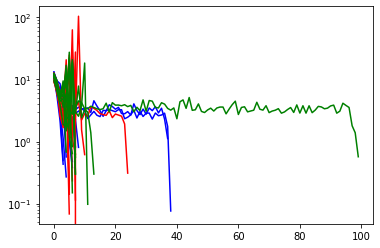

In [173]:
param_research(I,J,K,r,nb_rand,n_samples,beta=True)

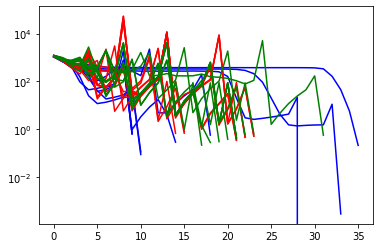

In [182]:
# with exact_error
param_research(I,J,K,r,nb_rand,n_samples,beta=True,exact_err=True)

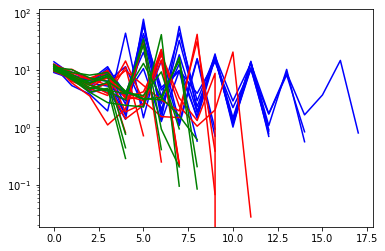

In [175]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,eta=True)

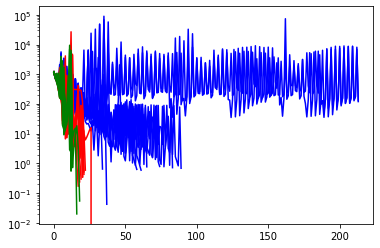

In [183]:
# with exact_error
param_research(I,J,K,r,nb_rand,n_samples,beta=False,eta=True,exact_err=True)

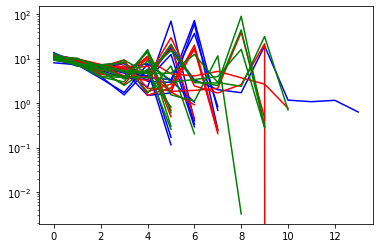

In [178]:
param_research(I,J,K,r,nb_rand,n_samples,beta=False,gamma=True)

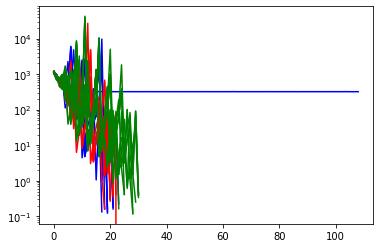

In [184]:
# with exact_error
param_research(I,J,K,r,nb_rand,n_samples,beta=False,gamma=True,exact_err=True)

### Comparaison of algorithms

In [185]:
def comparaison(I,J,K,r,nb_rand,n_samples,exact_err=False):
  list_err1=[]
  list_err2=[]
  min_e=None
  for i in range(nb_rand) : 
    # Random initialization of a noised cp_tensor
    A=np.random.normal(0, 1, size=(I, r))
    B=np.random.normal(0, 1, size=(J, r))
    C=np.random.normal(0, 1, size=(K, r))
    noise=np.random.normal(0, 0.001, size=(I,J,K))
    tensor=tl.cp_to_tensor((None,[A,B,C]))+noise
    norm_tensor=tl.norm(tensor,2)
    if(min_e==None) : min_e=norm_tensor
    weights1,factors1,it1,error1=her_CPRAND(tensor,r,n_samples,exact_err=exact_err,it_max=500,err_it_max=200) 
    weights2,factors2,it2,error2=als(tensor,r,it_max=500) 
    error1=[i * norm_tensor for i in error1]
    list_err1.append(error1)
    error2=[i * norm_tensor for i in error2]
    list_err2.append(error2)
    if (min_e>min(min(error1),min(error2))) : min_e=min(min(error1),min(error2))
  list_err1=[x-min_e for x in list_err1]
  list_err2=[x-min_e for x in list_err2]
  # plot
  for i in range(len(list_err1)):
    plt.plot(range(len(list_err1[i])),list_err1[i],'b-') 
  for i in range(len(list_err2)):
    plt.plot(range(len(list_err2[i])),list_err2[i],'r-') 
  plt.yscale("log") 

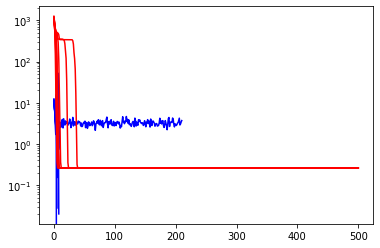

In [189]:
comparaison(I,J,K,r,nb_rand,n_samples)

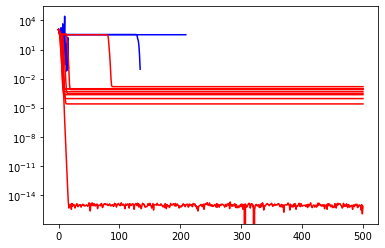

In [190]:
# with exact_err
comparaison(I,J,K,r,nb_rand,n_samples,exact_err=True)

plot median  
en fonction du temps